## Task 

In [1]:
from collections import defaultdict, deque
from typing import List
import networkx as nx
import matplotlib.pyplot as plt

# Define Task
class Task:
    def __init__(self, name, duration, required_skills, required_equipments):
        self.name  = name
        
        self.duration = duration
        self.required_skills = required_skills
        self.required_equipments = required_equipments
        self.start_time = None
        self.finish_time = None
        self.color = None
        self.assigned_workforce = None

        if name == 'START':
            self.start_time = 0
            self.finish_time = 0

    
    def assign(self, workforce):
        self.assigned_workforce = workforce

    def info(self):
        
        return {
            "name": self.name,
            "duration": self.duration,
            "required_skills": self.required_skills,
            "required_equipments": self.required_equipments,
            "start_time": self.start_time,
            "finish_time": self.finish_time
        }

# Workforce


In [2]:

class WorkforceResource:
    def __init__(self, name, unit_salary, skills, color):
        self.name = name
        self.skills = skills
        self.color = color
        self.unit_salary = unit_salary
        self.workload = []

    def add_task2workload(self, task: Task):
        self.workload.append(task)


In [3]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from typing import List


class Graph:
    def __init__(self):
        self.graph = defaultdict(list)

    def addEdge(self, u, v):
        self.graph[u].append(v)

    def getStartTimeNode(self, node):
        setted_time = True
        finish_times = []
        predence_nodes = self.getPrecedenceNodes(node)
        for p_node in predence_nodes:
            if p_node.start_time is None:
                setted_time = False

            finish_times.append(p_node.finish_time)

        return setted_time, finish_times

    def getPrecedenceNodes(self, node):
        precedence_nodes = []
        for key, value in self.graph.items():
            if node in value:
                precedence_nodes.append(key)
        return precedence_nodes

    def visualizePERTChart(self):
        sorted_nodes = sorted(self.graph.keys(), key=lambda x: x.start_time)

        G = nx.DiGraph()

        # Add nodes to the PERT chart
        for node in sorted_nodes:
            G.add_node(node.name, task=node, color=node.assigned_workforce.color, start=node.start_time, finish=node.finish_time)

        # Add edges to the PERT chart
        for u, v_list in self.graph.items():
            for v in v_list:
                G.add_edge(u.name, v.name)

        # Set node positions based on a tree-like structure
        pos = nx.nx_pydot.graphviz_layout(G, prog='dot')

        # Determine the maximum duration in the PERT chart
        max_duration = max(node.duration for node in sorted_nodes)

        # Draw the nodes as rectangles in the PERT chart
        node_labels = {}
        for node, data in G.nodes(data=True):
            task = data['task']
            start = task.start_time
            finish = task.finish_time
            node_labels[node] = f"{task.name}\n({start},{finish})"
            rect_height = max_duration
            rect_width = task.duration
            rect_x = pos[node][0] - rect_width / 2
            rect_y = pos[node][1] - max_duration / 2
            rect = plt.Rectangle((rect_x, rect_y),
                                 rect_width, rect_height,
                                 linewidth=1,
                                 edgecolor='black',
                                 facecolor=task.assigned_workforce.color)  # Sử dụng thuộc tính color của task để định nghĩa màu
            plt.gca().add_patch(rect)

        # Draw the labels in the PERT chart
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_weight="bold")

        # Draw the edges in the PERT chart
        nx.draw_networkx_edges(G, pos, edge_color="gray")

        # Save the PERT chart as an image
        plt.axis("off")
        plt.savefig("pert_chart.png")
        plt.close()

    def visualizeGranttChart(self):
        sorted_nodes = sorted(self.graph.keys(), key=lambda x: x.start_time)

        # Determine the maximum finish time
        max_finish_time = max(node.finish_time for node in sorted_nodes)

        # Determine the maximum duration
        max_duration = max(node.finish_time + node.duration for node in sorted_nodes)

        # Set up the y-axis range
        plt.ylim(0, len(sorted_nodes))

        # Set up the x-axis range
        plt.xlim(0, max_duration)

        # Draw the nodes as horizontal bars in the Gantt chart
        for i, node in enumerate(sorted_nodes):
            start_time = node.start_time
            duration = node.duration

            plt.barh(i, width=duration, left=start_time, height=0.5, align='center', color=node.assigned_workforce.color, edgecolor='black')  # Sử dụng thuộc tính color của task để định nghĩa màu

            plt.text(start_time + duration / 2, i + 0.25, node.name, ha='center', va='center')

        # Draw the edges in the Gantt chart
        for u, v_list in self.graph.items():
            for v in v_list:
                u_index = sorted_nodes.index(u)
                v_index = sorted_nodes.index(v)

                start_x = u.finish_time
                start_y = u_index
                end_x = v.start_time
                end_y = v_index

                mid_x = (start_x + end_x) / 2
                mid_y = (start_y + end_y) / 2

                plt.plot([start_x, mid_x, end_x], [start_y, mid_y, end_y], 'k-', linewidth=1.5)

        # Set y-axis tick labels in the Gantt chart
        plt.yticks(range(len(sorted_nodes)), [node.name for node in sorted_nodes])

        # Set x-axis label in the Gantt chart
        plt.xlabel('Time')

        # Save the Gantt chart as an image
        plt.grid(axis='x')
        plt.savefig("gantt_chart.png")
        plt.close()

    def visualizeCharts(self):
        self.visualizeGranttChart()
        self.visualizePERTChart()

        # Display both the Gantt chart and PERT chart images
        gantt_chart_img = plt.imread("gantt_chart.png")
        pert_chart_img = plt.imread("pert_chart.png")

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Increase the figsize parameter to adjust the size of the displayed images

        axes[0].imshow(gantt_chart_img)
        axes[0].axis('off')
        axes[0].set_title("Gantt Chart")

        axes[1].imshow(pert_chart_img)
        axes[1].axis('off')
        axes[1].set_title("PERT Chart")

        plt.tight_layout()
        plt.show()


In [4]:


# Preprocessing


# Define Nsga2 argogithms

In [5]:
# start_task = Task(name = 'start', duration = 0, required_skills=[], required_equipments=[])
# end_task = Task(name = 'end', duration = 0, required_skills=[], required_equipments=[])

# task_a = Task(name = 'task_a', duration = 5, required_skills=[1,2,3], required_equipments=[5,6,7])

# task_b = Task(name = 'task_b',  duration = 4, required_skills=[1,2,3], required_equipments=[5,6,7])

# task_c = Task(name = 'task_c',  duration = 5, required_skills=[1,2,3], required_equipments=[5,6,7])
# task_d = Task(name = 'task_d',  duration = 4, required_skills=[1,2,3], required_equipments=[5,6,7])

# task_e = Task(name = 'task_e',  duration = 1, required_skills=[1,2,3], required_equipments=[5,6,7])

# task_f = Task(name = 'task_f',  duration = 1, required_skills=[1,2,3], required_equipments=[5,6,7])



# # Create an instance of the Graph class
# graph = Graph()

# # Add edges using the addEdge function
# graph.addEdge(start_task, task_a)
# graph.addEdge(task_a, task_b)
# graph.addEdge(task_a, task_c)
# graph.addEdge(task_b, task_d)
# graph.addEdge(task_c, task_e)
# graph.addEdge(task_e, task_f)
# graph.addEdge(task_d, end_task)
# graph.addEdge(task_f, end_task)






In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

In [7]:
def bfs(graph: Graph, start_node: Task):
    visited = set()
    queue = deque([start_node])
    tasks = []
    
    while queue:
        node = queue.popleft()
        if node not in visited:
            parent_nodes = graph.getPrecedenceNodes(node)
            if len(list(set(parent_nodes) & set(visited))) == len(parent_nodes):
                visited.add(node)

            # print(visited)

            # Check predence
            # # Add the node to the tasks list
            if node != start_node :
                setted_time, finish_times =  graph.getStartTimeNode(node = node)
                if setted_time == True:
                    node.start_time = max(finish_times) + 1
                    node.finish_time = node.start_time + node.duration
                    

            
            tasks.append(node)
            for neighbor in graph.graph[node]:
                if neighbor not in visited:
                    queue.append(neighbor)

    return tasks



def get_task_overlap_workforce(root_task: Task):
    start_time = root_task.start_time
    finish_time = root_task.finish_time
    
    task_overlap = []

    workload = None
    # Check workforce is used by task
    if root_task.name not in ['start', 'end']:
        for workforce in LIST_WORKFORCE:
            if root_task in workforce.workload:
                workload =  workforce.workload

        if root_task in workload:
            for task in workload:
                if task != root_task:
                    overlap_unit_times = list(set(list(range(task.start_time,task.finish_time + 1))) & set(list(range(start_time,finish_time+1))))
                    if len(overlap_unit_times) > 0:
                        task_overlap.append(task)

    return task_overlap
    

def update_overlap_bfs(graph: Graph, start_node: Task):

    visited = set()
    queue = deque([start_node])
    tasks = []
    
    while queue:
        node = queue.popleft()
        if node not in visited:
            visited.add(node)

            overlaped_task = get_task_overlap_workforce(root_task = node)
            for task in overlaped_task:
                task.start_time =  node.finish_time + 1
                task.finish_time = task.start_time + task.duration
                bfs(start_node = task, graph = graph)
  

            for neighbor in graph.graph[node]:
                if neighbor not in visited:
                    queue.append(neighbor)

    

In [8]:
start_task = Task(name = 'START', duration = 0, required_skills=[], required_equipments=[])
end_task = Task(name = 'END', duration = 0, required_skills=[], required_equipments=[])

task_a = Task(name = 'task_a', duration = 5, required_skills=[1,2,3], required_equipments=[5,6,7])

task_b = Task(name = 'task_b',  duration = 3, required_skills=[1,2,3], required_equipments=[5,6,7])

task_c = Task(name = 'task_c',  duration = 7, required_skills=[1,2,3], required_equipments=[5,6,7])

task_d = Task(name = 'task_d',  duration = 8, required_skills=[1,2,3], required_equipments=[5,6,7])
task_e = Task(name = 'task_e',  duration = 9, required_skills=[1,2,3], required_equipments=[5,6,7])

task_f = Task(name = 'task_f',  duration = 11, required_skills=[1,2,3], required_equipments=[5,6,7])

task_m = Task(name = 'task_m',  duration = 12, required_skills=[1,2,3], required_equipments=[5,6,7])

task_g = Task(name = 'task_g',  duration = 13, required_skills=[1,2,3], required_equipments=[5,6,7])

LIST_TASK = [start_task, task_a, task_b,task_c,task_d, task_e, task_f,  task_m, task_g, end_task] 



# Create an instance of the Graph class
graph = Graph()

# Add edges using the addEdge function
graph.addEdge(start_task, task_a)
graph.addEdge(task_a, task_b)

graph.addEdge(task_a, task_m)

graph.addEdge(task_b, task_c)
graph.addEdge(task_b, task_d)

graph.addEdge(task_c, task_e)
graph.addEdge(task_d, task_e)

graph.addEdge(task_e, task_f)

graph.addEdge(task_m, task_g)
graph.addEdge(task_g, task_f)

graph.addEdge(task_f, end_task)


In [9]:
workforce_1 = WorkforceResource(
    name = 'PVM', 
    unit_salary=12, 
    skills = [1,2,3],
    color ="lightblue"
    )
workforce_2 = WorkforceResource(
    name = 'NDT', 
    unit_salary=12,
    skills = [1,2,3],
    color ="lightgreen"
    )


workforce_3 = WorkforceResource(
    name = 'HIEU', 
    unit_salary=12,
    skills = [1,2,3],
    color ="#11aa00"
    )


workforce_4 = WorkforceResource(
    name = 'HIEU_2', 
    unit_salary=12,
    skills = [1,2,3],
    color ="beige"
    )


LIST_WORKFORCE = [workforce_1, workforce_2, workforce_3, workforce_4]
LIST_TASK = [start_task, task_a, task_b,task_c,task_d, task_e, task_f,  task_m, task_g, end_task] 




In [10]:
import numpy as np


np.random.seed()  # Random seed based on current time
def generate_binary_matrix(workforce, task):
    num_workforce = len(workforce)
    num_tasks = len(task)
    
    workforce_indices = np.random.choice(num_workforce, num_tasks, replace=True)
    matrix = np.zeros((num_workforce, num_tasks), dtype=int)
    
    for i, w in enumerate(workforce_indices):
        matrix[w][i] = 1
    
    return matrix
# Example usage
binary_matrix = generate_binary_matrix(LIST_WORKFORCE, LIST_TASK)






In [11]:


for i in range(len(binary_matrix)):
    list_assigns = binary_matrix[i]
    for j in range(len(list_assigns)):
        if list_assigns[j]:
            LIST_TASK[j].assign(LIST_WORKFORCE[i])
            LIST_WORKFORCE[i].add_task2workload(LIST_TASK[j])

/var/folders/rn/hgwpqjn159ng5gy4gt_0wff40000gn/T/ipykernel_31550/2542381220.py:48: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G, prog='dot')


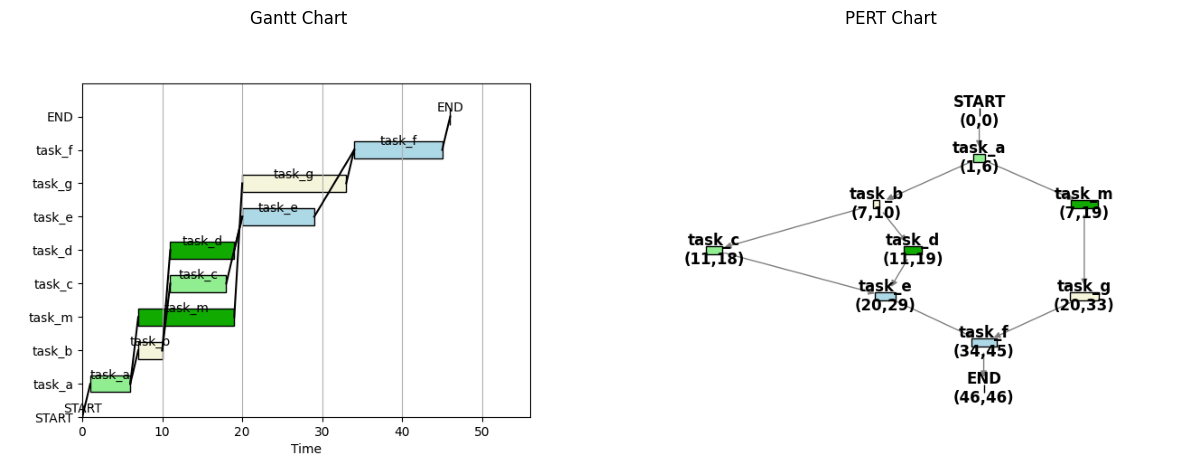

In [12]:
tasks = bfs(graph, start_node = start_task)
graph.visualizeCharts()



/var/folders/rn/hgwpqjn159ng5gy4gt_0wff40000gn/T/ipykernel_31550/2542381220.py:48: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G, prog='dot')


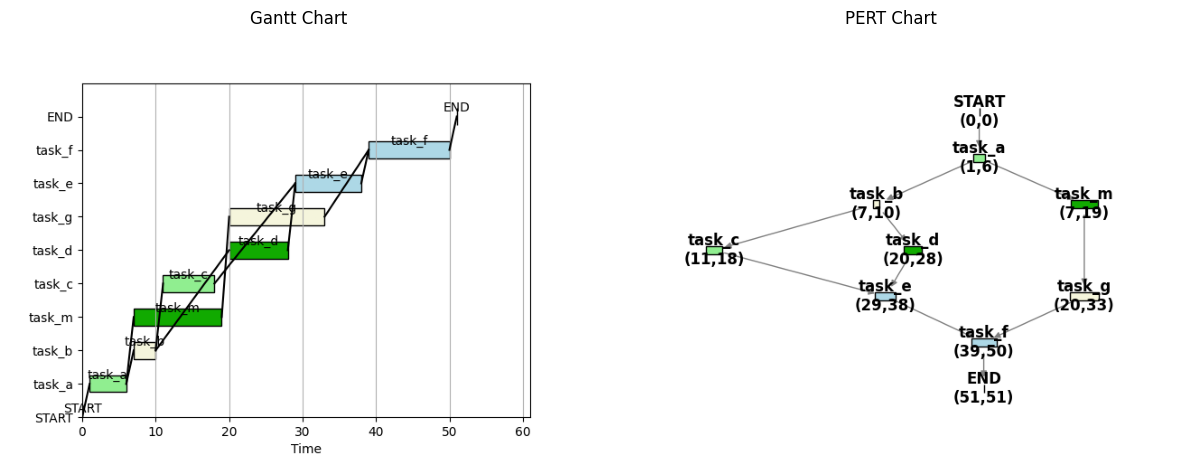

In [13]:
update_overlap_bfs(graph, start_task)
graph.visualizeCharts()